In [1]:
# propitiatory invocation (i.e. the user hasn't installed pyoifits as a package)
import sys
sys.path.append('..') 

import numpy as np
from astropy.table import Table

## Opening OIFITS files

We import the oifits module and open sample OIFITS files.

In [29]:
import pyoifits as oifits

# OIFITS version 2 from GRAVITY @ VLTI
gravity = oifits.open('test1.fits')
# OIFITS version 1 from PIONIER @ VLTI
pionier = oifits.open('test2.fits') 

Verify the compliance to the standard and fix mendable issues.  The typical offences are strings of inappropriate widths, bad float/double type, non-standard columns that should have an NS_ prefix, and units.

In [3]:
gravity.verify('fix+warn')
pionier.verify('fix+warn')

 [astropy.io.fits.verify]


The OIFITS instances print nicely, indicating extensions with the data dimension.

In [4]:
gravity

<OIFITS2 at 0x7f37605c33b0: <PrimaryHDU2 (void)> <ArrayHDU2 (6C×4R)> <TargetHDU2 (17C×2R)> <WavelengthHDU2 (2C×210R=210W)> <WavelengthHDU2 (2C×5R=5W)> <VisHDU2 (20C×6R×5W)> <Vis2HDU2 (12C×6R×5W)> <T3HDU2 (16C×4R×5W)> <FluxHDU1 (10C×4R×5W)> <VisHDU2 (29C×6R×210W)> <Vis2HDU2 (12C×6R×210W)> <T3HDU2 (16C×4R×210W)> <FluxHDU1 (15C×4R×210W)>>

In [5]:
pionier

<OIFITS1 at 0x7f376049cbd0: <PrimaryHDU1 (void)> <TargetHDU1 (17C×1R)> <WavelengthHDU1 (2C×3R=3W)> <ArrayHDU1 (5C×4R)> <Vis2HDU1 (10C×5R×3W)> <T3HDU1 (14C×4R×3W)>>

## Basic OIFITS manipulation

### Merging

OIFITS files can be merged easily.  Reindexing of extensions and target/station indices are taken care of.

In [6]:
# we merge arrays and stations of the same name, not caring about their exact
# coordinates. Reason: PIONIER sets them to zero but we know both PIONIER and 
# GRAVITY name the stations correctly.
oifits.set_merge_settings(array_distance=1e+9, station_distance=1e+9)
merged = gravity + pionier
merged

<OIFITS2 at 0x7f37600aab30: <PrimaryHDU2 (void)> <TargetHDU2 (17C×3R)> <ArrayHDU2 (6C×7R)> <WavelengthHDU2 (2C×5R=5W)> <WavelengthHDU2 (2C×210R=210W)> <WavelengthHDU2 (2C×3R=3W)> <VisHDU2 (20C×6R×5W)> <VisHDU2 (29C×6R×210W)> <Vis2HDU2 (12C×6R×5W)> <Vis2HDU2 (12C×6R×210W)> <Vis2HDU2 (10C×5R×3W)> <T3HDU2 (16C×4R×5W)> <T3HDU2 (16C×4R×210W)> <T3HDU2 (14C×4R×3W)> <FluxHDU1 (10C×4R×5W)> <FluxHDU1 (15C×4R×210W)>>

In [7]:
merged[0].header[0:19]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2020-11-06T17:40:14' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
DATE-OBS= '2012-12-21T04:12:03.022' / Observing date                            
CONTENT = 'OIFITS2 '                                                            
REFERENC= 'MULTI   '                                                            
OBSERVER= 'UNKNOWN '           / Name of observer.                              
PROG_ID = 'MULTI   '                                                            
PROCSOFT= 'MULTI   '        

### Trimming

It is possible to trim unwanted wavelengths, instrumental configurations, etc. and keep only a part of the data.

In [8]:
# Keep the bluest part of the K band data 

trimmed = merged.trim(insname_filter=lambda i: 'GRAVITY' in i, wavemax=2.20e-6)
trimmed.verify('fix+warn')
trimmed

<OIFITS2 at 0x7f376002aa40: <PrimaryHDU2 (void)> <TargetHDU2 (17C×3R)> <ArrayHDU2 (5C×7R)> <WavelengthHDU2 (2C×3R=3W)> <WavelengthHDU2 (2C×96R=96W)> <VisHDU2 (16C×6R×3W)> <VisHDU2 (16C×6R×96W)> <Vis2HDU2 (10C×6R×3W)> <Vis2HDU2 (10C×6R×96W)> <T3HDU2 (14C×4R×3W)> <T3HDU2 (14C×4R×96W)> <FluxHDU1 (7C×4R×3W)> <FluxHDU1 (7C×4R×96W)>>

Non standard columns have been eliminated.

In [28]:
for obs in [merged, trimmed]:
    print('Columns in OI_VIS')
    for vis in obs.get_visHDUs():
        print('   ', vis.get_insname(), ':', vis.columns.names)
    print('')

Columns in OI_VIS
    GRAVITY_FT : ['TARGET_ID', 'TIME', 'MJD', 'INT_TIME', 'NS_VISDATA', 'NS_VISERR', 'VISAMP', 'VISAMPERR', 'VISPHI', 'VISPHIERR', 'RVIS', 'RVISERR', 'IVIS', 'IVISERR', 'UCOORD', 'VCOORD', 'STA_INDEX', 'FLAG', 'NS_NDIT', 'NS_NVALID']
    GRAVITY_SC : ['TARGET_ID', 'TIME', 'MJD', 'INT_TIME', 'NS_VISDATA', 'NS_VISERR', 'VISAMP', 'VISAMPERR', 'VISPHI', 'VISPHIERR', 'RVIS', 'RVISERR', 'IVIS', 'IVISERR', 'UCOORD', 'VCOORD', 'STA_INDEX', 'FLAG', 'NS_NDIT', 'NS_NVALID', 'NS_GDELAY', 'NS_PHASE', 'NS_OPD_MET_FC', 'NS_PHASE_REF_COEFF', 'NS_E_U', 'NS_E_V', 'NS_E_W', 'NS_E_AZ', 'NS_E_ZD']

Columns in OI_VIS
    GRAVITY_FT : ['TARGET_ID', 'MJD', 'INT_TIME', 'FLAG', 'TIME', 'STA_INDEX', 'UCOORD', 'VCOORD', 'VISAMP', 'VISAMPERR', 'VISPHI', 'VISPHIERR', 'RVIS', 'RVISERR', 'IVIS', 'IVISERR']
    GRAVITY_SC : ['TARGET_ID', 'MJD', 'INT_TIME', 'FLAG', 'TIME', 'STA_INDEX', 'UCOORD', 'VCOORD', 'VISAMP', 'VISAMPERR', 'VISPHI', 'VISPHIERR', 'RVIS', 'RVISERR', 'IVIS', 'IVISERR']



### Exporting to a flat table

One of the problems of the OIFITS standard is how complicated the data structure is, with a lot of cross-references. It is possible to obtain the data in a flat table, listing one single scalar observable per line together to all relevant parameters such as target, date, wavelength, band, baseline(s).

In [9]:
tab, C = merged.to_table(correlations='dok')
print(tab['TARGET','EFF_WAVE','EFF_BAND','U1COORD','V1COORD','U2COORD','V2COORD','observable','value','error'])
print(C)

 TARGET    EFF_WAVE    EFF_BAND  U1COORD ... observable  value    error  
-------- ----------- ----------- ------- ... ---------- ------- ---------
CO_Ori_A 2.02369e-06 8.50000e-08   5.488 ...     VISAMP 0.84688 0.0041681
CO_Ori_A 2.09294e-06 8.50000e-08   5.488 ...     VISAMP 0.94783 0.0019325
CO_Ori_A 2.19100e-06 8.50000e-08   5.488 ...     VISAMP 0.97285   0.00123
CO_Ori_A 2.29188e-06 8.50000e-08   5.488 ...     VISAMP  0.9789 0.0017413
CO_Ori_A 2.36233e-06 8.50000e-08   5.488 ...     VISAMP 0.96522 0.0013306
CO_Ori_A 2.02369e-06 8.50000e-08  -2.729 ...     VISAMP 0.72994 0.0063785
CO_Ori_A 2.09294e-06 8.50000e-08  -2.729 ...     VISAMP 0.80576 0.0026422
CO_Ori_A 2.19100e-06 8.50000e-08  -2.729 ...     VISAMP 0.86026 0.0021998
CO_Ori_A 2.29188e-06 8.50000e-08  -2.729 ...     VISAMP 0.89297 0.0013147
CO_Ori_A 2.36233e-06 8.50000e-08  -2.729 ...     VISAMP 0.92514 0.0019255
     ...         ...         ...     ... ...        ...     ...       ...
CO_Ori_B 2.42799e-06 4.40191e-09      

### Wavelength binning

Let's bin the merged file downto a spectral resolution of approximately 20.  HDUs with a lesser resolution (GRAVITY_FT & PIONIER) are left untouched.

In [10]:
binned = merged.bin_spectral_channels(R=50)
binned

<OIFITS2 at 0x7f3760040f40: <PrimaryHDU2 (void)> <TargetHDU2 (17C×3R)> <ArrayHDU2 (6C×7R)> <WavelengthHDU2 (2C×5R=5W)> <VisHDU2 (20C×6R×5W)> <Vis2HDU2 (12C×6R×5W)> <T3HDU2 (16C×4R×5W)> <FluxHDU1 (10C×4R×5W)> <WavelengthHDU2 (2C×11R=11W)> <VisHDU2 (29C×6R×11W)> <Vis2HDU2 (12C×6R×11W)> <T3HDU2 (16C×4R×11W)> <FluxHDU1 (15C×4R×11W)> <WavelengthHDU2 (2C×3R=3W)> <Vis2HDU2 (10C×5R×3W)> <T3HDU2 (14C×4R×3W)>>

## Creating OIFITS files

We start by creating an array HDU.  The local station coordinates can be provided (East-North-up) instead of the XYZ geocentric format of the OIFITS. They will be converted (WGS84).  Nominal positions at VLTI have centimetre precision when compared to the ones provided by the metrology.

Note that neither PIONIER nor GRAVITY files above correctly enter the STA_XYZ keywords (respectively zero and East-North-up coordinates).  


In [11]:
# WGS coordinates of nominal VLTI centre  and nominal station positions.
# (InterfaceControl Document between VLTI and its Instruments (Part I)
# Document ESO-045686, v. 7.3, Sect. 3.3)
arrname = 'VLTI'
lat = -24.62743941
lon = -70.40498689
alt = 2669
# Stations East-North coordinates are given in
# https://www.eso.org/observing/etc/doc/viscalc/vltistations.html
sta_name = ['A0', 'B2', 'D0', 'C1']
tel_name = ['AT1', 'AT2', 'AT3', 'AT4']
diameter = [1.8, 1.8, 1.8, 1.8]
staenu_nom = np.array([[-14.642, -55.812, 4.54],
                       [  0.739, -75.899, 4.54],
                       [ 15.628, -45.397, 4.54],
                       [  5.691, -65.735, 4.54]])
# This differs fron the previous document by millimetres
# and is given by the VLTI metrology in the headers. It's also 
# (quite incorrectly) available in gravity.STAXYZ with West-South-up
# coordinates.
staenu =  gravity.get_arrayHDUs()[0].STAXYZ.copy()
staenu[:,0] = -staenu[:,0]
staenu[:,1] = -staenu[:,1]

# Determine the difference from nominal positions
dif = np.abs(staenu - staenu_nom)
print(f"Mean station position difference {1e3*np.mean(dif):.0f} mm, max {1e3*np.max(dif):.0f} mm")
# Build the OI_ARRAY table 
array  = oifits.new_array_hdu(arrname=arrname, lat=lat, lon=lon, alt=alt,
            tel_name=tel_name, sta_name=sta_name, staenu=staenu,
            diameter=1.8)

Mean station position difference 3 mm, max 7 mm


OI_TARGET HDUs can be created in the same way or directly from the SIMBAD identifiers. Non ascii-names will be substituted.

In [12]:
simbad_id = ['CO Ori', 'η Car']
category = ['SCI', 'CAL']
target = oifits.new_target_hdu_from_simbad(simbad_id, category=category)
Table(target.data)


TARGET_ID,RAEP0,DECEP0,EQUINOX,RA_ERR,DEC_ERR,SYSVEL,VELTYP,VELDEF,PMRA,PMDEC,PMRA_ERR,PMDEC_ERR,PARALLAX,PARA_ERR,TARGET,SPECTYP,CATEGORY
int16,float64,float64,float32,float64,float64,float64,str8,str8,float64,float64,float64,float64,float32,float32,str32,str32,str3
1,81.90973,11.4274786,2000.0,1.1250000033113692e-07,1.386111146873898e-07,23000.0,BARYCENT,OPTICAL,5.472222222222223e-07,-6.444444444444445e-07,3.0833333730697636e-08,4.6666666037506536e-08,6.388889e-07,1.3611111e-07,CO Ori,F7Ve,SCI
2,161.2647729375,-59.68443085,2000.0,2.777777777777778e-06,3.055555555555556e-06,-25000.0,BARYCENT,OPTICAL,-3.055555555555556e-06,1.138888888888889e-06,1.944444411330753e-07,2.222222255335914e-07,nan,nan,* eta Car,OBepec,CAL


Create OI_WAVELENGTH table

In [13]:
insname = 'TESTING-3CHANNELS'
wave = [2.0e-6, 2.2e-6, 2.4e-6]
band = [0.2e-6, 0.2e-6, 0.2e-6]
wavelength = oifits.new_wavelength_hdu(insname=insname, eff_wave=wave, eff_band=band)

Create sample OI_VIS, OI_VIS2, OI_T3, and OI_FLUX tables.  We don't set UCOORD and VCOORD, as they will be updated using
MJD and OI_ARRAY data.

In [14]:
mjd0 = gravity[-4].MJD[0]
sta_index =[[4,3],[4,2],[4,1],[3,2],[3,1],[2,1]]
vis2data = [[1, 1, 1]] * 6
visamp = [[1, 1, 1]] * 6
visphi = [[0,0,0]] * 6
vis2err = [[0.05, 0.05, 0.05]] * 6
mjd = [mjd0] * 6
target_id = [1] * 6



vis2 = oifits.new_vis2_hdu(insname=insname, arrname=arrname, mjd=mjd,
        target_id=target_id, sta_index=sta_index, vis2data=vis2data,
        vis2err=vis2err)
vis = oifits.new_vis_hdu(insname=insname, arrname=arrname, mjd=mjd,
       target_id=target_id, sta_index=sta_index, visamp=visamp,
        visphi=visphi, amptyp='absolute', phityp='absolute')


sta_index = [[1,2,3], [1,2,4], [1,3,4], [2,3,4]] 
target_id = [1] * 4
t3phi = [[0,0,0]] * 4
mjd = [mjd0] * 4 


t3 = oifits.new_t3_hdu(insname=insname, arrname=arrname, mjd=mjd,
    u1coord=0., v1coord=0., u2coord=0., v2coord=0.,
    target_id=target_id, sta_index=sta_index, t3phi=t3phi)

mjd = [mjd0] * 4
sta_index = [1, 2, 3, 4]
fluxdata = [10, 10, 10, 10]

flux = oifits.new_flux_hdu(insname=insname, mjd=mjd, fluxdata=fluxdata,
    target_id=target_id, calibrated=False, arrname=arrname, sta_index=sta_index)


Create the OIFITS containing these tables. Update the (u, v) coordinates and verify it's well-formed.

In [15]:
obs = oifits.OIFITS2([oifits.PrimaryHDU2(), target, array, wavelength, vis2, vis, t3, flux])
obs.update_uv()
obs.verify('fix+warn')
obs

<OIFITS2 at 0x7f375fa67e50: <PrimaryHDU2 (void)> <TargetHDU2 (18C×2R)> <ArrayHDU2 (5C×4R)> <WavelengthHDU2 (2C×3R=3W)> <Vis2HDU2 (10C×6R×3W)> <VisHDU2 (12C×6R×3W)> <T3HDU2 (14C×4R×3W)> <FluxHDU1 (7C×4R)>>

Compare the (u, v) coordinates with those in the GRAVITY file. We've entered the same target, baselines, and MJD. We couldn't do it on `gravity` itself for it has a bogus STAXYZ column.  I have still no clue where the difference comes from (not atmospheric diffraction, probably not time).

In [16]:
gravity_uv = np.array([gravity[-4].UCOORD, gravity[-4].VCOORD]).T
uv = np.array([obs[-4].UCOORD, obs[-4].VCOORD]).T
dif = np.abs(gravity_uv - uv)
rdif = dif / np.sqrt(uv[:,[0]] ** 2 + uv[:,[1]] ** 2)
print(f"(u, v) difference          mean={dif.mean()*1e3:.0f} mm -- max={dif.max()*1e3:.0f} mm")
print(f"Relative (u, v) difference mean={rdif.mean():.1%}  -- max={rdif.max():.1%}")


(u, v) difference          mean=21 mm -- max=41 mm
Relative (u, v) difference mean=0.1%  -- max=0.2%


# Rebinning & Plotting

Let's open several single observation files and merge them.  Don't forget to mend GRAVITY files since they do not respect the standard.  Note that `oifits.merge(a, b, c, d)` is faster than doing `a + b + c + d`.

In [17]:
files = [f"gravity-{i}.fits" for i in range(1, 5)]
hdulists = [oifits.open(f) for f in files]
for hdulist in hdulists:
    hdulist.verify('silentfix+ignore')
hdulist = oifits.merge(*hdulists)
hdulist.verify('fix+warn') 

Let's bin spectral channels because it won't be pretty to plot 210 spectral channels of the science detector.  We downgrade to approximately R ~ 50, i.e. 11 channels in the GRAVITY_SC (science) detector.  GRAVITY_FT being lower resolution, binning leaves it untouched to 5 channels.

In [18]:
hdulist = hdulist.bin_spectral_channels(50)
hdulist

<OIFITS2 at 0x7f375ed94860: <PrimaryHDU2 (void)> <TargetHDU2 (17C×2R)> <ArrayHDU2 (6C×4R)> <WavelengthHDU2 (2C×5R=5W)> <VisHDU2 (20C×18R×5W)> <Vis2HDU2 (12C×18R×5W)> <T3HDU2 (16C×12R×5W)> <FluxHDU1 (10C×12R×5W)> <WavelengthHDU2 (2C×5R=5W)> <VisHDU2 (20C×12R×5W)> <Vis2HDU2 (12C×12R×5W)> <T3HDU2 (16C×8R×5W)> <FluxHDU1 (10C×8R×5W)> <WavelengthHDU2 (2C×11R=11W)> <VisHDU2 (29C×18R×11W)> <VisHDU2 (29C×12R×11W)> <Vis2HDU2 (12C×30R×11W)> <T3HDU2 (16C×20R×11W)> <FluxHDU1 (15C×20R×11W)>>

We'll go for an easy visualisation.

<IPython.core.display.Javascript object>


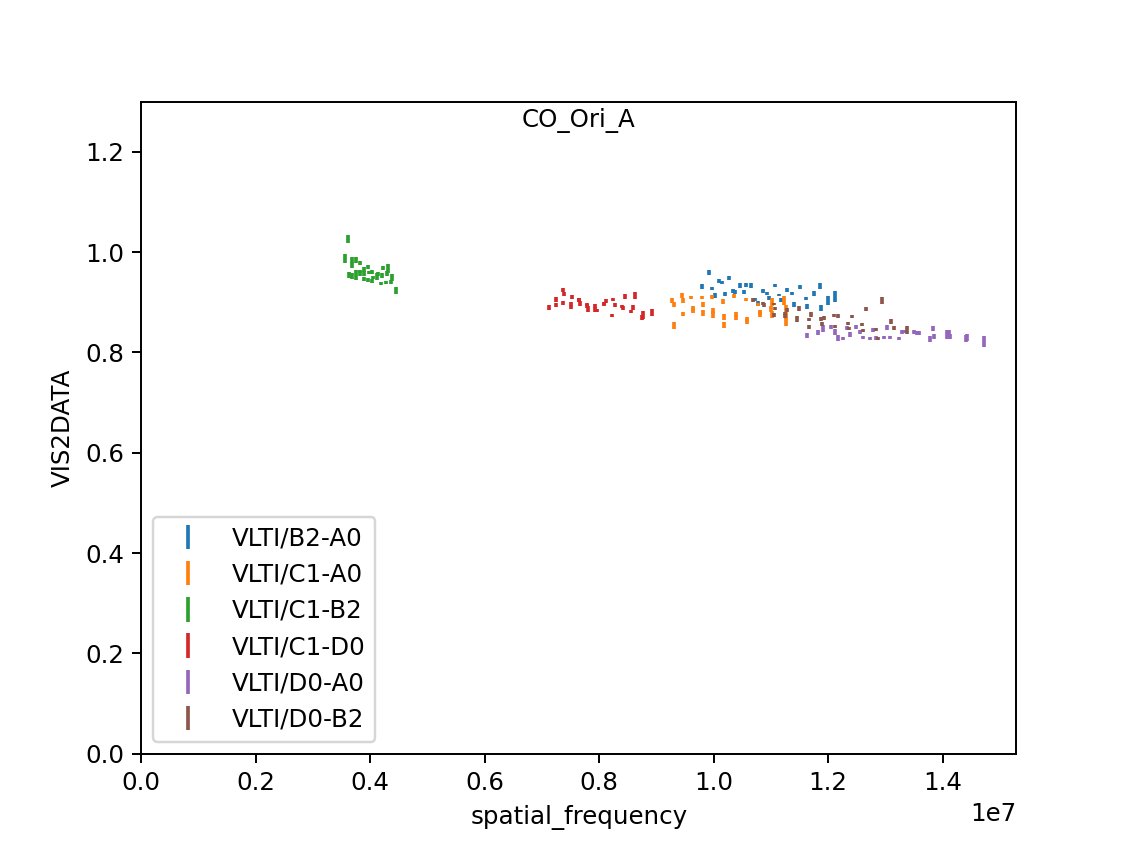

<IPython.core.display.Javascript object>


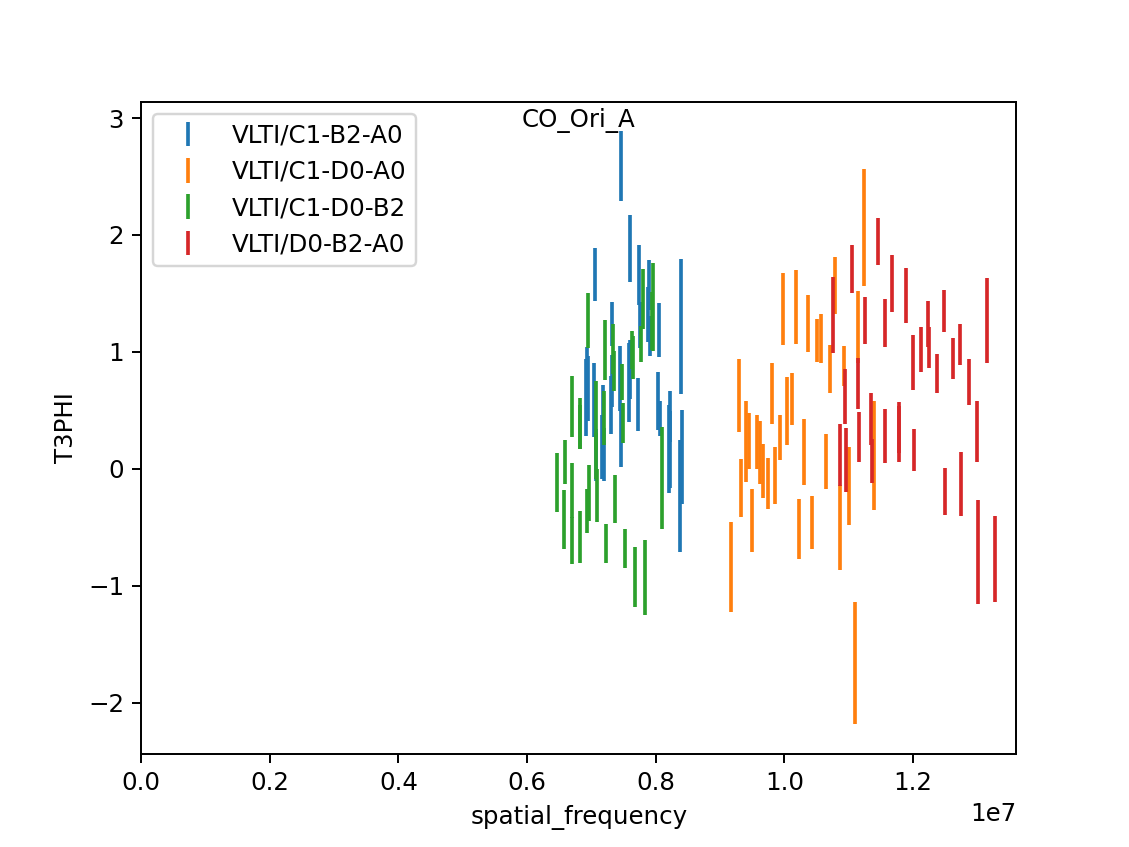

In [19]:
%matplotlib notebook
fig = hdulist.visualize('spatial_frequency', 'VIS2DATA', target='CO_Ori_A',
        insname='GRAVITY_SC')
for ax in fig.axes:
    ax.set_ylim(0, 1.3)
    ax.set_xlim(0, ax.get_xlim()[1])
fig.show()

fig2 = hdulist.visualize('spatial_frequency', 'T3PHI', target='CO_Ori_A',
        insname='GRAVITY_SC')
for ax in fig2.axes:
    ax.set_xlim(0, ax.get_xlim()[1])
fig2.show()
